# Part 1: Time Series Analysis (1 day)📈

What is a time serie ? Simply put, it's a dataset where each value is measured at a known given time. Whether it's stock prices, temperature measurements, sales figures, or any other sequential data, time series data holds a rich tapestry of information about how phenomena evolve over time. Typically with time series, we want to estimate the evolution of a phenomenom with time i.e. make predictions for the future. Thus, the temporal order of the dataset is of paramount significance!

Unlike cross-sectional data, where observations are independent of each other, the temporal arrangement in time series carries inherent dependencies. Patterns, trends, and seasonal variations often emerge, providing invaluable insights into the behavior of the underlying process.

In this notebook, we will manipulate a simple time series dataset with Pandas to explore the following concepts:
- Patterns (Trend, Seasonality, Noise) and Additive / Multiplicative decomposition
- Stationarity & Heteroskedasticity (Differencing & Log transform)
- Autocorrelation (ACF, PACF)

**Objectives**
- Get to know the theory behind time series
- Analyse time series datasets with Pandas
- Discover main time series analysis challenges

**Resources**

- https://www.youtube.com/watch?v=FsroWpkUuYI&list=PLjwX9KFWtvNnOc4HtsvaDf1XYG3O5bv5s
- https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
- https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html
- https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python
- https://perso.math.univ-toulouse.fr/jydauxoi/files/2017/04/poly_eleves.pdf

**Required librairies**
- [ ] numpy
- [ ] pandas
- [ ] matplotlib
- [ ] seaborn
- [ ] pmdarima

In [100]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm

# 1. Manipulate time series with Pandas

### 1.1 Load & visualize the Air Passengers dataset ✈️ 💺

Learn how to manipulate a Pandas series.

**Resources**
- https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
- https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html

**TODO**
- Load and visualize the dataset
- What can you tell about the overall trend of the data ?
- Select and plot a specific year (e.g. 1952) from the data using the `.index.year` attribute

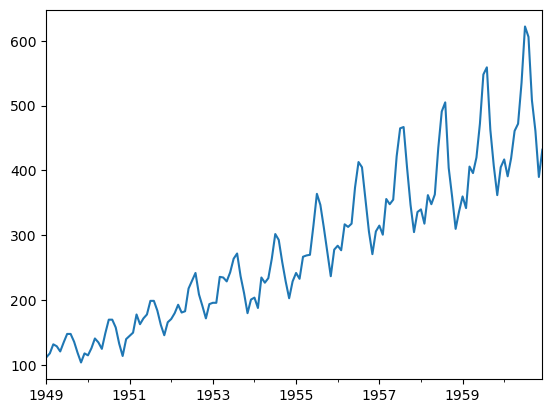

In [101]:
from pmdarima.datasets import load_airpassengers

# Load dataset
START_DATE = '1949-01-01'
airline = load_airpassengers(as_series=True)

# There's no DateTimeIndex from the bundled dataset. So let's add one.
airline.index = pd.date_range(START_DATE, periods=len(airline), freq='MS')

# Write definitions to visualize, describe and eventually clean data
airline.plot()
plt.show()


### 1.2 Change the sampling (D/M/Y)

Different months have different numbers of days. Calculating the number of passengers per day might help remove this uninteresting variation from the series!

**TODO**
- Create a new time serie representing the daily number of passengers using the `.index.days_in_month` attribute
- Visualize the old and new serie: do you observe any difference ?

[Text(0.5, 0, 'Month'), Text(0, 0.5, 'Passengers per day (thousands)')]

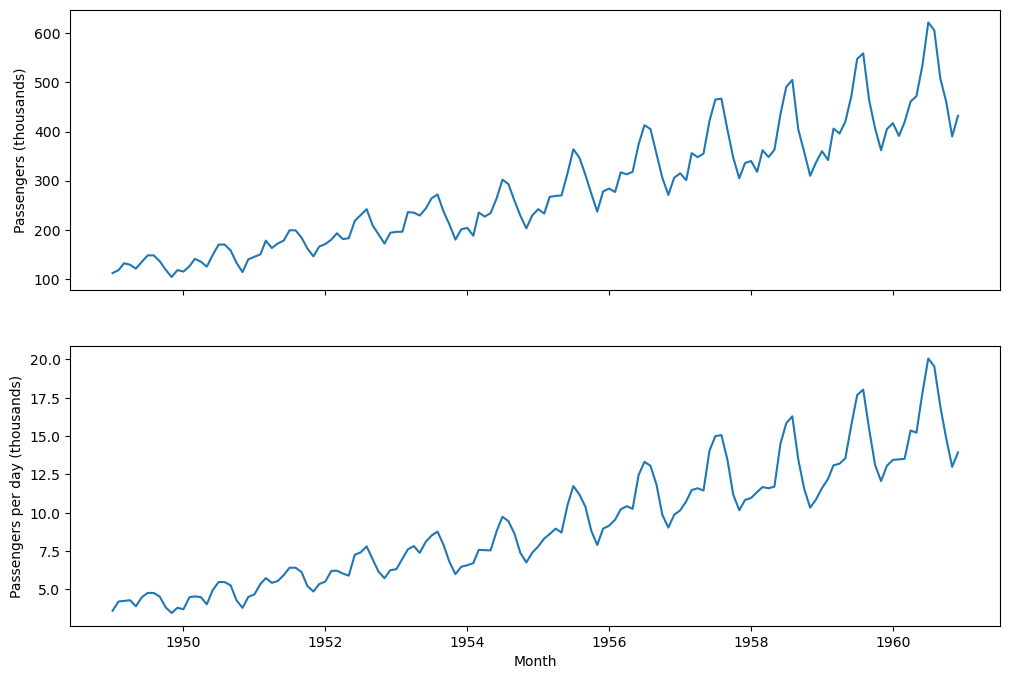

In [102]:
# Calculate the number of airline passengers per day instead of months
# Create the PeriodIndex object
nb_days_month = airline.index.days_in_month
airline_adj = airline/nb_days_month

# Plot the unadjusted and adjusted series
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))

axes[0].plot(airline)
axes[0].set(ylabel='Passengers (thousands)')

axes[1].plot(airline_adj)
axes[1].set(xlabel='Month', ylabel='Passengers per day (thousands)')

### 1.3 Interpolation

Interpolation is useful when there are missing values which we don't want to discard completely. As such, it can be used instead of the now well-known `dropna()` method.

Another use case for interpolation is when resampling a time series. The airline passengers data is given with 1 month intervals. What if we want to know (and predict) the airline frequentation at smaller intervals ? For this we can use the `resample()` and `interpolate` methods!

**Resources**
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html <br/>

**TODO**
- Select a single year from the dataset and resample it to daily time
- Call `resample()` to resample the series to daily intervals
- Call `interpolate()` and play with the different methods
- Plot the results to show the differences  

In [103]:
# year 1955 - using .index- to use in a serie 
airline1955 = airline[airline.index.year == 1955]

# Resample dataset to daily time - will change just one point to 30 points bt wont put any data inside.
airline1955resample = airline1955.resample('D')


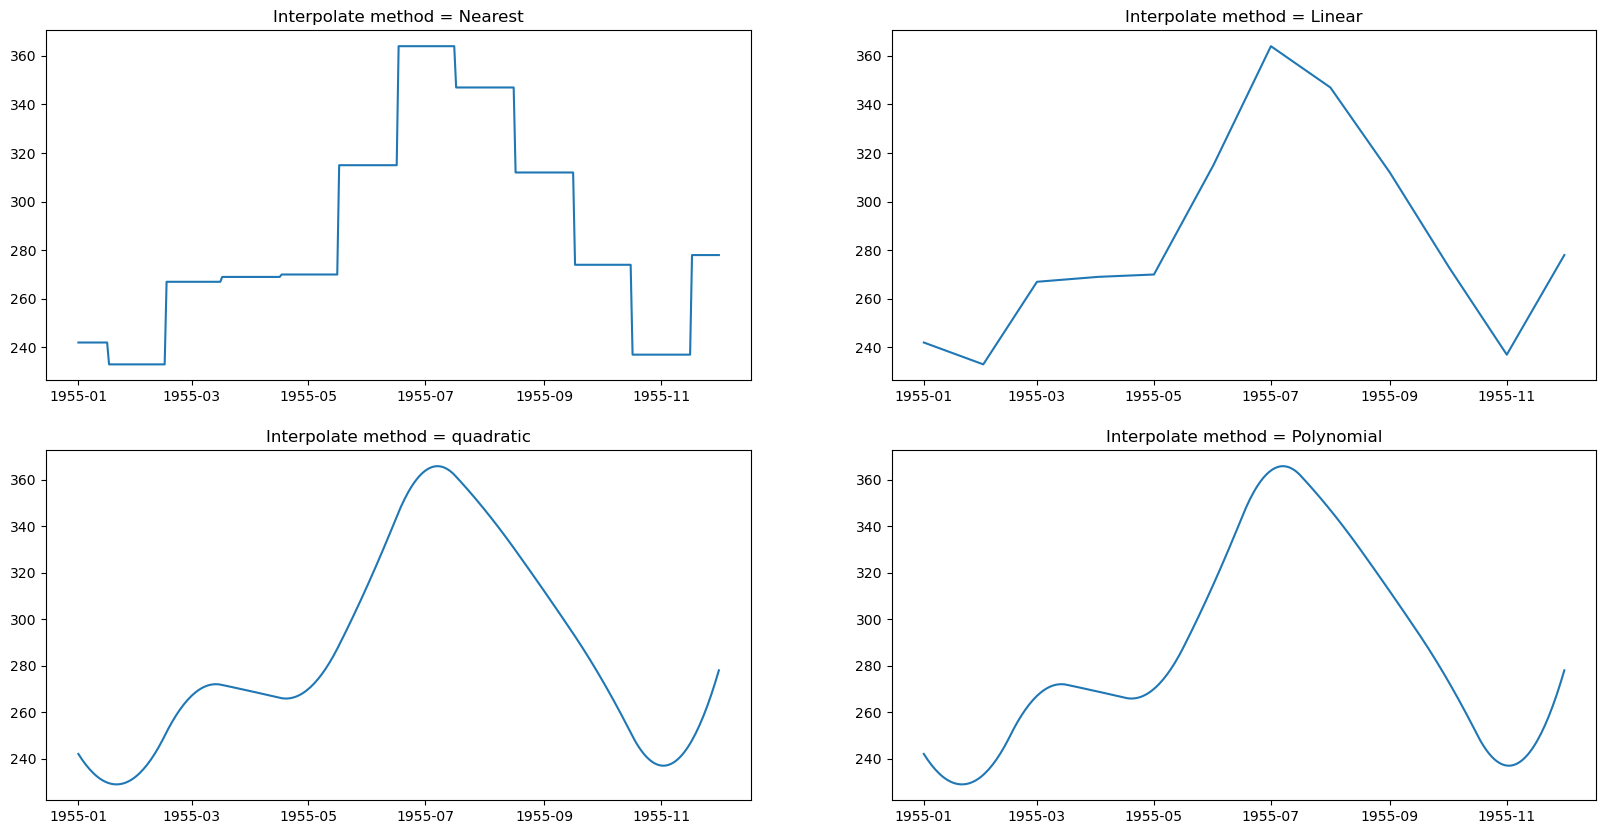

In [104]:
#Interpolate -- the goal is to fill out the new sample 

#Method = Nearest
airline_inter_nearest = airline1955resample.interpolate(method = 'nearest')

#Method = Linear
airline_inter_linear = airline1955resample.interpolate(method = 'slinear')

#Method = quadrique
airline_inter_quadratic = airline1955resample.interpolate(method = 'quadratic')

#Method = polynomial
airline_inter_polynomial = airline1955resample.interpolate(method = 'polynomial', order=5)


#Visu
fig = plt.figure(figsize = (20,10))

ax= fig.add_subplot(2,2,1)
ax.plot(airline_inter_nearest)
ax.set_title('Interpolate method = Nearest')

ax1 = fig.add_subplot(2,2,2)
ax1.plot(airline_inter_linear)
ax1.set_title('Interpolate method = Linear')

ax2 = fig.add_subplot(2,2,3)
ax2.plot(airline_inter_quadratic)
ax2.set_title('Interpolate method = quadratic')

ax3 = fig.add_subplot(2,2,4)
ax3.plot(airline_inter_quadratic)
ax3.set_title('Interpolate method = Polynomial')


plt.show()


# 2. Identifying patterns: Trend & Seasonality

**Theory**

To analyze, and eventually forecast, a time series, it is useful to break it down into simple components. Typically, a time series is modeled as the contribution of three components:
- The Trend $T$: long-term movement or direction of the time series, related to the underlying growth or decline such as in upward, downward or flat trend
- The Seasonality $S$: repeating patterns or fluctuations that occur in a time series at regular intervals, such as daily, weekly, monthly, or yearly patterns
- The Residuals $R$: residual random variations or noise that cannot be explained by the trend and seasonality

Decomposing the signal into these components is useful for
- Removing noise arising from measurement errors or random fluctuations
- Isolate trend and seasonality to model and analyze them separately
- Make better forecasts

There are two main types of seasonal decomposition: the **additive** and **multiplicative** decomposition.
The additive model tries to find the best possible components $T_t$, $S_t$, $R_t$ such that at all times $t$ the serie $Y_t$ is decomposed as
$$ Y_t = T_t + S_t + R_t$$  
The additive model is linear since the variations of the trend and seasonality are independent of each other. When the seasonal (periodic) variations in the time serie seem to be independent of the trend, additive models are preferred. 

Conversely, the multiplicative model tries to find the best possible components $T_t$, $S_t$, $R_t$ such that at all times $t$ the serie $Y_t$ is decomposed as
$$ Y_t = T_t * S_t * R_t$$
Note that the multiplicative model can be seen as an additive model in log-space, i.e. it is completely equivalent to
$$ \log Y_t = \log T_t + \log S_t + \log R_t$$
Multiplicatrive models are non linear since the variations in the trend imply variations in seasonality, and vice-versa. When the seasonal variations in the time series seems to change with time, multiplicative models are preferred.

--------------------

**Resources**

- https://medium.com/analytics-vidhya/time-series-decomposition-part-i-trend-cycle-computation-29fac227896a
- https://otexts.com/fpp2/components.html
- https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html<br/>
- https://towardsdatascience.com/time-series-analysis-resampling-shifting-and-rolling-f5664ddef77e

--------------------

**TODO**

Back to the monthly dataset (do not continue with the interpolated one).
- Use the function `seasonal_decompose()` from Statmodels to decompose the dataset into its components with both an additive and multiplicative model.
- Visualize the results. Which model works best ?
- Perform your own decomposition using the `rolling()` method from Pandas.

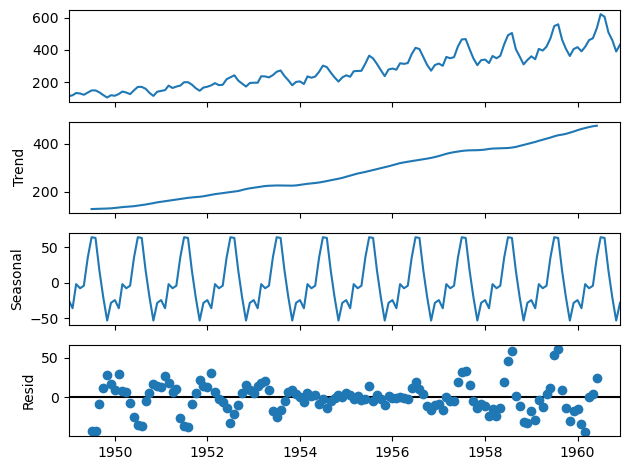

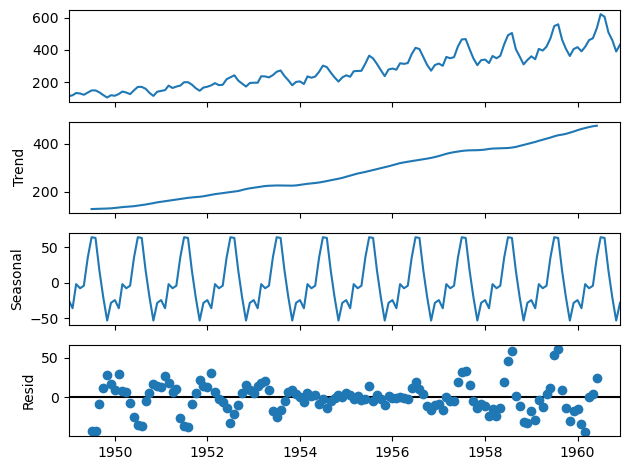

In [105]:
from statsmodels.tsa.seasonal import seasonal_decompose
#Model = Addictive
airline_decompose_additive = seasonal_decompose(airline, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)

#Model = Multiplicative 
airline_decompose_multiplicative = seasonal_decompose(airline, model='multipliative', filt=None, period=None, two_sided=True, extrapolate_trend=0)

#Visu Method additive
airline_decompose_additive.plot()


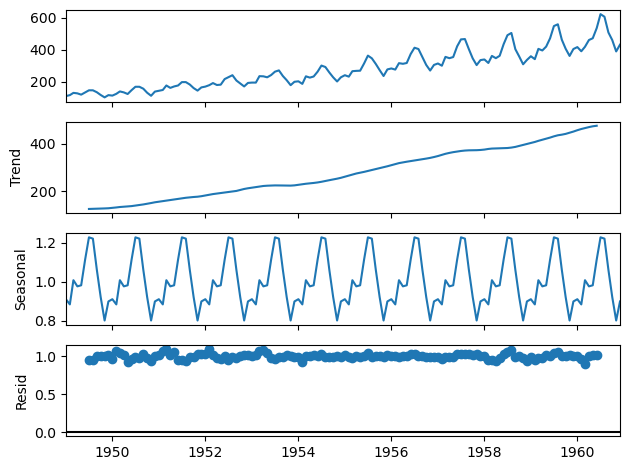

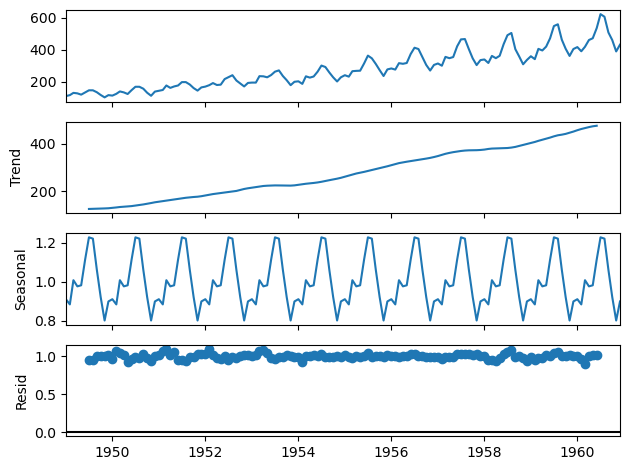

In [106]:
#Visu Method Multiplicative
airline_decompose_multiplicative.plot()


In [107]:
def monthly_average(data):
    avg = data.groupby(data.index.month).mean()
    index = pd.date_range(START_DATE, periods=len(airline), freq='MS')
    
    data = np.zeros(len(index))
    
    for i,n in enumerate(index):
        data[i] = avg[n.month]

    new_data = pd.Series(data=data, index=index)
    
    return new_data


def custom_seasonal(data, model='additive'):
    
    # Compute the trend = rolling mean
    Trend = data.rolling(window = len(data)).mean()


    if model == 'additive':
        
        # Subtract the trend to get the seasonal + noise component
        seasonal_plus_noise = model - Trend

        # Take the average over each month to get the pure seasonal component


        # The residual is the difference between the data and trend + seasonal
        pass
        
    elif model == 'multiplicative':
        
        # Divice by the trend to get the seasonal * noise component


        # Take the average over each month to get the pure seasonal component


        # The residual is the division between the data and trend * seasonal
        pass
        
    else:
        raise ValueError('Unknown model name')
    
    # Plot results
    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 8))
    
    axes[0].plot(data)
    axes[1].plot(trend)
    axes[2].plot(seasonal)
    axes[3].plot(residual)

#custom_seasonal(airline_adj)

# 3. Stationarity

### 3.1 Stationarity & Heteroskedasticity

**Theory**

A time series is a series of data points indexed in time. The fact that time series data are ordered makes them unique in the data space, as they often display serial dependency. Serial dependence occurs when the value of a data point at one point in time is statistically dependent on another data point at another point in time. However, this attribute of time series data violates one of the fundamental assumptions of many statistical analyses - that the data are statistically independent (Independent & Identically Distributed, IID, see https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) !

Thus, we often need to assess some less restricting properties in order to deal (and model) time series. A time series is said to be *stationary* when its properties (such as the mean, the variance, the autocorrelation, etc...) do not change over time. This is a very useful property because it is the assumption underlying many predictive models in time series forecasting. Trends can result in a varying mean over time, whereas seasonality can result in a changing variance over time, and both will result in a non-stationary time serie. Specifically, *heteroskedasticity* refers to the property of having a non-constant variance. Thus, if a time serie is heteroskedastic, it is not stationary!

**Resources**
- https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322
- https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

**TODO**
- Plot the time serie along with is rolling mean and variance.
- Is this time serie stationary or not? Why ?
- What about heteroskedasticity?

Text(0.5, 1.0, 'Rolling STD')

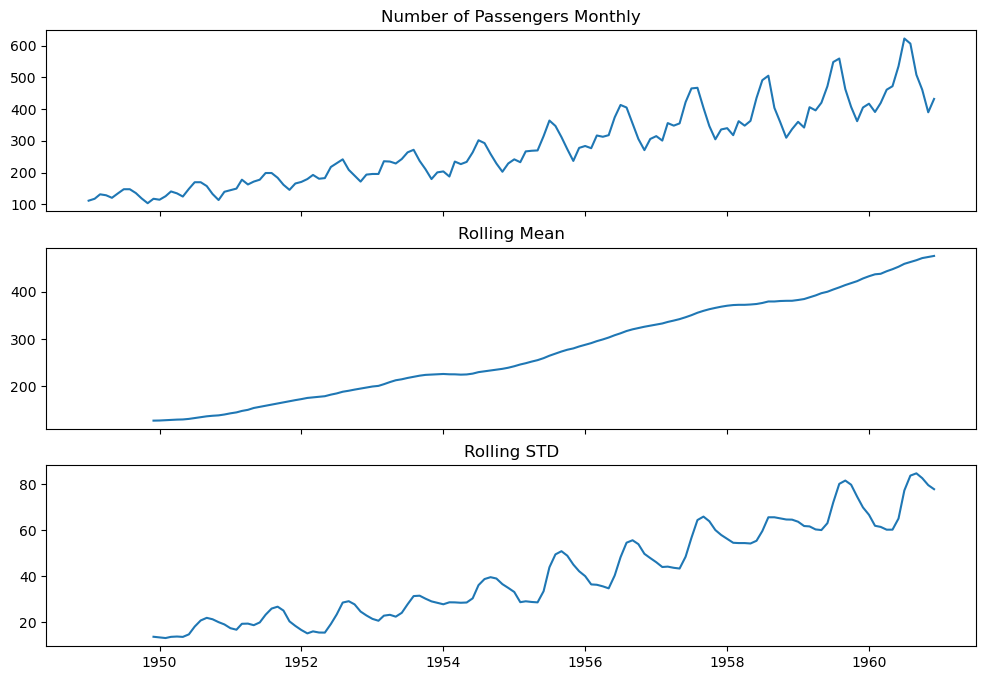

In [108]:
# Plot1: Combined Plot to assess
# - "Passengers"
# - "Rolling mean"
# - "Rolling standard deviation"

# Plot results
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
axes[0].plot(airline)
axes[0].set_title('Number of Passengers Monthly')
axes[1].plot(airline.rolling(window=12).mean())
axes[1].set_title('Rolling Mean')
axes[2].plot(airline.rolling(window = 12).std())
axes[2].set_title('Rolling STD')

The mean is not constant and the variance increase over time so this time seri is not stationary.

### 3.2 Differencing

If the time series at hand is not stationary, we can apply some transformations to make it stationary. The difference transform helps stabilizing the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality. For a time series $Y_t$, its (first-order) difference $D_t$ is defined as
$$D_t = Y_t - Y_{t-1}$$
If you apply this difference transform iteratively, you can achieve what is called $n^{th}$-order differentiation!

**TODO**
- Write a function to compute the first-order difference of the time series and plot it.
- Check your results by comparing to Pandas `.diff()` method.
- What can you say about the trend and the seasonality ?
- What about heteroskedasticity ?

In [109]:
def difference(data):
    # Compute the difference series
    diff = [data[i] - data[i - 1] for i in range(1,len(data))]
    return diff
    
# Compute difference and plot
difference(airline)

/tmp/ipykernel_15812/2713144079.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff = [data[i] - data[i - 1] for i in range(1,len(data))]


[np.float64(6.0),
 np.float64(14.0),
 np.float64(-3.0),
 np.float64(-8.0),
 np.float64(14.0),
 np.float64(13.0),
 np.float64(0.0),
 np.float64(-12.0),
 np.float64(-17.0),
 np.float64(-15.0),
 np.float64(14.0),
 np.float64(-3.0),
 np.float64(11.0),
 np.float64(15.0),
 np.float64(-6.0),
 np.float64(-10.0),
 np.float64(24.0),
 np.float64(21.0),
 np.float64(0.0),
 np.float64(-12.0),
 np.float64(-25.0),
 np.float64(-19.0),
 np.float64(26.0),
 np.float64(5.0),
 np.float64(5.0),
 np.float64(28.0),
 np.float64(-15.0),
 np.float64(9.0),
 np.float64(6.0),
 np.float64(21.0),
 np.float64(0.0),
 np.float64(-15.0),
 np.float64(-22.0),
 np.float64(-16.0),
 np.float64(20.0),
 np.float64(5.0),
 np.float64(9.0),
 np.float64(13.0),
 np.float64(-12.0),
 np.float64(2.0),
 np.float64(35.0),
 np.float64(12.0),
 np.float64(12.0),
 np.float64(-33.0),
 np.float64(-18.0),
 np.float64(-19.0),
 np.float64(22.0),
 np.float64(2.0),
 np.float64(0.0),
 np.float64(40.0),
 np.float64(-1.0),
 np.float64(-6.0),
 np.float6

In [110]:
# Compare with Pandas
airline.diff()

1949-01-01     NaN
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
              ... 
1960-08-01   -16.0
1960-09-01   -98.0
1960-10-01   -47.0
1960-11-01   -71.0
1960-12-01    42.0
Freq: MS, Length: 144, dtype: float64

Differencing can also be used to remove seasonality. In the above equations, we defined $D_t$ as the difference between two *consecutive*  values of the time series. But we can also take the difference on a larger interval of time, called the lag, $l$:
$$ D_t = Y_t - Y_{t-l}$$
where $l$ can be any integer $>1$. If we set $l$ to match the cyclic pattern of our time series, then we expect the difference transform to eliminate the seasonality. Let's try this out!

In [111]:
def difference(data, lag):
    # Compute the difference series

    diff = [data[i] - data[i - lag] for i in range(1,len(data))]
    return diff
    
# Compute difference and plot
difference(airline, lag = 12)

/tmp/ipykernel_15812/1431304332.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff = [data[i] - data[i - lag] for i in range(1,len(data))]


[np.float64(-273.0),
 np.float64(-287.0),
 np.float64(-332.0),
 np.float64(-351.0),
 np.float64(-400.0),
 np.float64(-474.0),
 np.float64(-458.0),
 np.float64(-372.0),
 np.float64(-342.0),
 np.float64(-286.0),
 np.float64(-314.0),
 np.float64(3.0),
 np.float64(8.0),
 np.float64(9.0),
 np.float64(6.0),
 np.float64(4.0),
 np.float64(14.0),
 np.float64(22.0),
 np.float64(22.0),
 np.float64(22.0),
 np.float64(14.0),
 np.float64(10.0),
 np.float64(22.0),
 np.float64(30.0),
 np.float64(24.0),
 np.float64(37.0),
 np.float64(28.0),
 np.float64(47.0),
 np.float64(29.0),
 np.float64(29.0),
 np.float64(29.0),
 np.float64(26.0),
 np.float64(29.0),
 np.float64(32.0),
 np.float64(26.0),
 np.float64(26.0),
 np.float64(30.0),
 np.float64(15.0),
 np.float64(18.0),
 np.float64(11.0),
 np.float64(40.0),
 np.float64(31.0),
 np.float64(43.0),
 np.float64(25.0),
 np.float64(29.0),
 np.float64(26.0),
 np.float64(28.0),
 np.float64(25.0),
 np.float64(16.0),
 np.float64(43.0),
 np.float64(54.0),
 np.float64(46

In [112]:
# Compare with Pandas
airline.diff(periods = 12)

1949-01-01     NaN
1949-02-01     NaN
1949-03-01     NaN
1949-04-01     NaN
1949-05-01     NaN
              ... 
1960-08-01    47.0
1960-09-01    45.0
1960-10-01    54.0
1960-11-01    28.0
1960-12-01    27.0
Freq: MS, Length: 144, dtype: float64

### 3.3 Log-transform

We will see that ARIMA models can take into account an increasing mean over time, but not the variance. In this case, we specifically want to get rid of the heteroskedasticity. To this aim, a very common operation is to apply a log transform.

The log transform is very simple, it's just $\tilde{Y}_t = \log Y_t$.

**TODO**
- Compute the log transform of the time series and plot it.
- Is it stationary ?

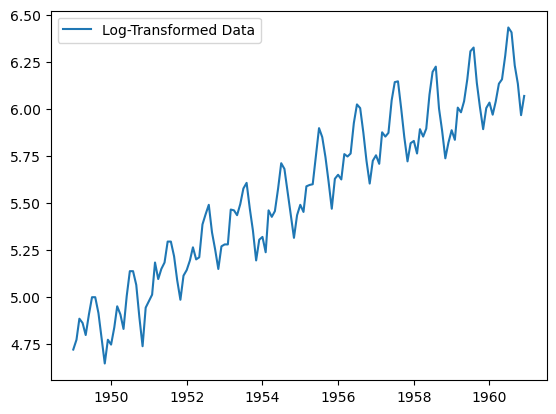

In [113]:
# Compute log transform and show the plot
log_transform = np.log(airline)

#Visu
plt.plot(log_transform, label='Log-Transformed Data')
plt.legend()
plt.show()

#Important - the log take off the heterodeskaticity (the variation of the variance) but not the trend! 

### 3.4 Putting it all together

You now know how to detrend a dataset and how to tame heteroskedasticity. Let's see if we can use and combine these tools to make our time series stationary. To check if the transformed serie is indeed stationary, you can use two different stationarity tests: the *Augmented Dickey Fuller (ADF)* test and the *Kwiatkowski-Phillips-Schmidt-Shin (KPSS)* test.
Note that the Null Hypothesis of the ADF test is that the serie is non-stationary, whereas the Null Hypothesis of the KPSS test is that the serie is stationary!


**TODO**
- Apply the log transform and differentiate the time series. Does the order matter ? Why ?
- Plot the transformed time serie along with is rolling mean and variance. What do you observe ?
- Perform the ADF and KPSS tests before and after your transformation. Is the transformed time serie stationary ?

In [114]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

#For ADF model- model is stationary if p-value <= 0.05
#For KPSS model is stationary if p-value >0.05

In [115]:
# Perform the ADF and KPSS tests before the transformation 

adf_test(airline)

#p-value > 0.05 

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [116]:
#KPSS tests before the transformation 
kpss_test(airline)

Results of KPSS Test:
Test Statistic           1.651312
p-value                  0.010000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/tmp/ipykernel_15812/2441874341.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


In [135]:
#Apply the log transform and differentiate the time series. Does the order matter ? Why ?

data_transformed = np.log(airline_adj)

data_trans_diff = data_transformed.diff(periods = 1)
data_trans_diff = data_trans_diff.diff(periods = 12)



In [136]:
#Perform the ADF and KPSS tests before the transformation 
adf_test(data_trans_diff.dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -4.502289
p-value                          0.000195
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [137]:
kpss_test(data_trans_diff.dropna())

Results of KPSS Test:
Test Statistic           0.072189
p-value                  0.100000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/tmp/ipykernel_15812/2441874341.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


# 4. Auto-correlation

**Theory**

We said earlier that time series are particular because they show a serial (temporal) dependence, namely observations at a certain time $t$ are statistically correlated to previous observations. It will be useful to our analysis to measure quantitatively this serial dependence with the help of the mathematical tools of *Covariance*, *Correlation* and the related *Auto-Correlation*.

Let's first recall some definitions.
- The sample mean of $X$ is $\mu_X = \frac{1}{N} \sum_{i=1}^N X_i$ is a measure of the expected average value.
- The variance of $X$ is $V_X = \frac{1}{N} \sum_{i=1}^N (X_i - \mu_X)^2$, it is a measure of the squared deviation around the mean.
- The standard deviation of $X$ is $\sigma_X = \sqrt{V_X}$, it is a measure of the Root-Mean-Square deviation around the mean.
- The covariance of two series $X$ and $Y$ is $V(X,Y) = \frac{1}{N} \sum_{i=1}^N (X_i - \mu_X)(Y_i - \mu_Y)$, it is a measure of the joint variability of the two series.
- The correlation of two series $X$ and $Y$ is $C(X,Y) = V(X,Y) / \sigma_X \sigma_Y$, it is a measure of the statistical correlation ("Normalized Covariance") of the two series.

Finally, the Auto-Correlation Function (ACF) $ A_X(h) = C(Y_t, Y_{t-h}) $ measures for each lag $h = 1, 2, 3, ...$ the average correlation of a time series with a lagged version of itself. It measures the correlation of an observation $Y_t$ with the one $h$ time stamps before $Y_{t-h}$, on average over all the observations!

One more thing: while the ACF measures the **full** correlation between $Y$ and $Y_{t-h}$, the **Partial** Auto-Correlation Function (PACF) measures only the **direct** correlation between $Y$ and $Y_{t-h}$, by removing the contribution from the intermediate correlations. Its calculation is not unique and sometimes relies on models, so we will not say how it's calculated here.

--------------------

**Resources**
- https://towardsdatascience.com/understanding-autocorrelation-in-time-series-analysis-322ad52f2199
- https://emel333.medium.com/interpreting-autocorrelation-partial-autocorrelation-plots-for-time-series-analysis-23f87b102c64

--------------------

**TODO**
- Plot the ACF and PACF of the original &  transformed dataset (log + diff)
- Can you interpret the differences ?
- Can you find the periodicity by looking at the ACF/PACF on the transformed dataset ?

In [138]:
data_trans_diff

1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
                ...   
1960-08-01   -0.045934
1960-09-01    0.012024
1960-10-01    0.031830
1960-11-01   -0.050082
1960-12-01   -0.009964
Freq: MS, Length: 144, dtype: float64

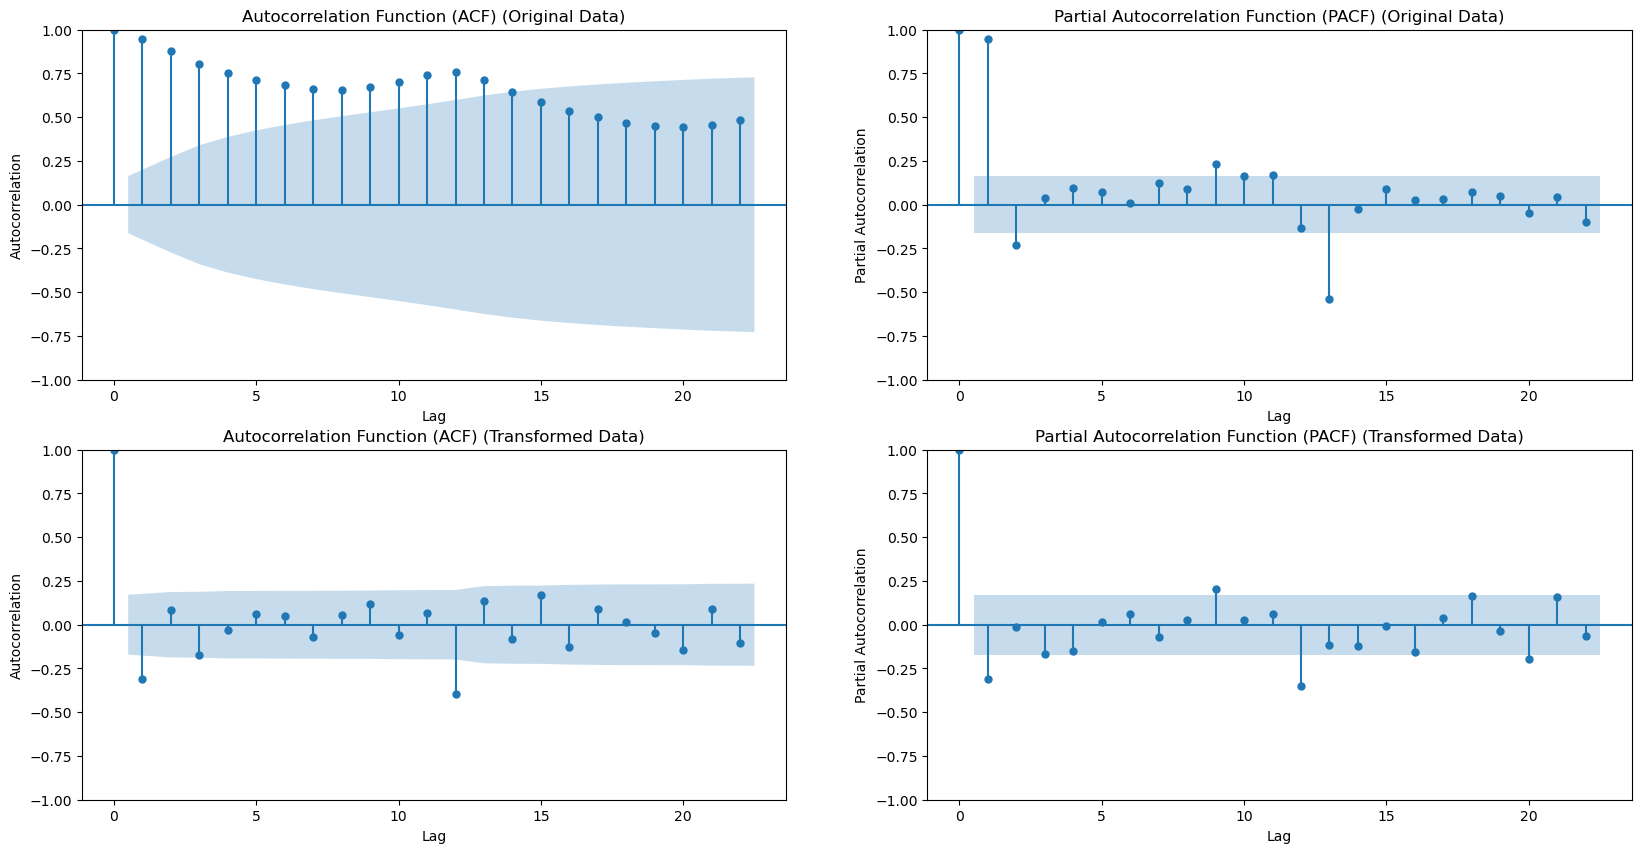

In [140]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF and PACF
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(2,2,1)
plot_acf(airline, ax=ax)
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Function (ACF) (Original Data)")

# Plot PACF

ax1 = fig.add_subplot(2,2,2)
plot_pacf(airline, ax=ax1)
ax1.set_xlabel("Lag")
ax1.set_ylabel("Partial Autocorrelation")
ax1.set_title("Partial Autocorrelation Function (PACF) (Original Data)")


ax2 = fig.add_subplot(2,2,3)
plot_acf(data_trans_diff.dropna(), ax=ax2)
ax2.set_xlabel("Lag")
ax2.set_ylabel("Autocorrelation")
ax2.set_title("Autocorrelation Function (ACF) (Transformed Data)")

# Plot PACF

ax3 = fig.add_subplot(2,2,4)
plot_pacf(data_trans_diff.dropna(), ax=ax3)
ax3.set_xlabel("Lag")
ax3.set_ylabel("Partial Autocorrelation")
ax3.set_title("Partial Autocorrelation Function (PACF) (Transformed Data)")


plt.show() 

 

# Bonus

## Bonus #1 Questions

**TODO**
- Think of a *very basic* way to predict the number of passengers on the next month ? Show your results. What's the source of the error ?
- Extend your method to predict a whole year ? Show your results. Again, what's the error ?

## Bonus #2 Automatization

**TODO - Write a class with the following methods:**
* A `check format` method to check format and eventually change it to datetime format
* A `visualize` method with <span style="color:red"> Plotly</span>
* A `seasonal_decompose` method setting the relevant attributes (trend, seasonality, residual)
* A `plot_acf` and `plot_pacf` method
* A `transform` method (differencing, log)
* A `report` method to provide a report about observations on your dataset.

## Bonus #3 Fast Fourier Transform (FFT)

**Resources**

- https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/

**TODO**

- The Fourier Transform is related to the ACF... How ?
- Analyse the frequency spectrum of the dataset. What is the meaning of the different frequency peaks ?
- Plot the signal obtained by keeping only the most prominent frequencies. Is this enough to describe all the variations in the signal ?
- What is the meaning of high frequencies ? What would be a meaningful frequency cutoff ?
